<a href="https://colab.research.google.com/github/singaravelan/TensorFlow_programming/blob/main/7.%20Speech%20Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
import os
import zipfile
import wget

# Specify the URL and destination folder
download_url = 'https://www.dropbox.com/scl/fi/a7sfjtcopfykm6qs7i5hh/Human-Emotional-Speech-YAF.zip?rlkey=1zn3qsbxv93rxy9od5p4fpvdv&raw=1'
destination_folder = 'data'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Download the file using wget
zip_file_path = os.path.join(destination_folder, 'Human-Emotional-Speech-YAF.zip')
wget.download(download_url, zip_file_path)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Remove the downloaded zip file if needed
os.remove(zip_file_path)

print(f'Data downloaded and extracted to: {destination_folder}')


Data downloaded and extracted to: data


In [ ]:
TRAIN_DATASET_PATH = 'data/Human Emotional Speech YAF/Train'
TEST_DATASET_PATH = 'data/Human Emotional Speech YAF/Test'
BATCH_SIZE = 64
VAL_SPLIT = 0.2
OUTPUT_SEQUENCE_LENGTH = 32000

In [ ]:
data_dir = pathlib.Path(TRAIN_DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    seed=0,
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 1344 files belonging to 7 classes.


Using 1076 files for training.
Using 268 files for validation.

label names: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'pleasant_surprised' 'sad']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
    # Check if audio has a single channel
        # Squeeze only along the last axis
    audio = tf.squeeze(audio, axis=-1)

    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 32000)
(64,)


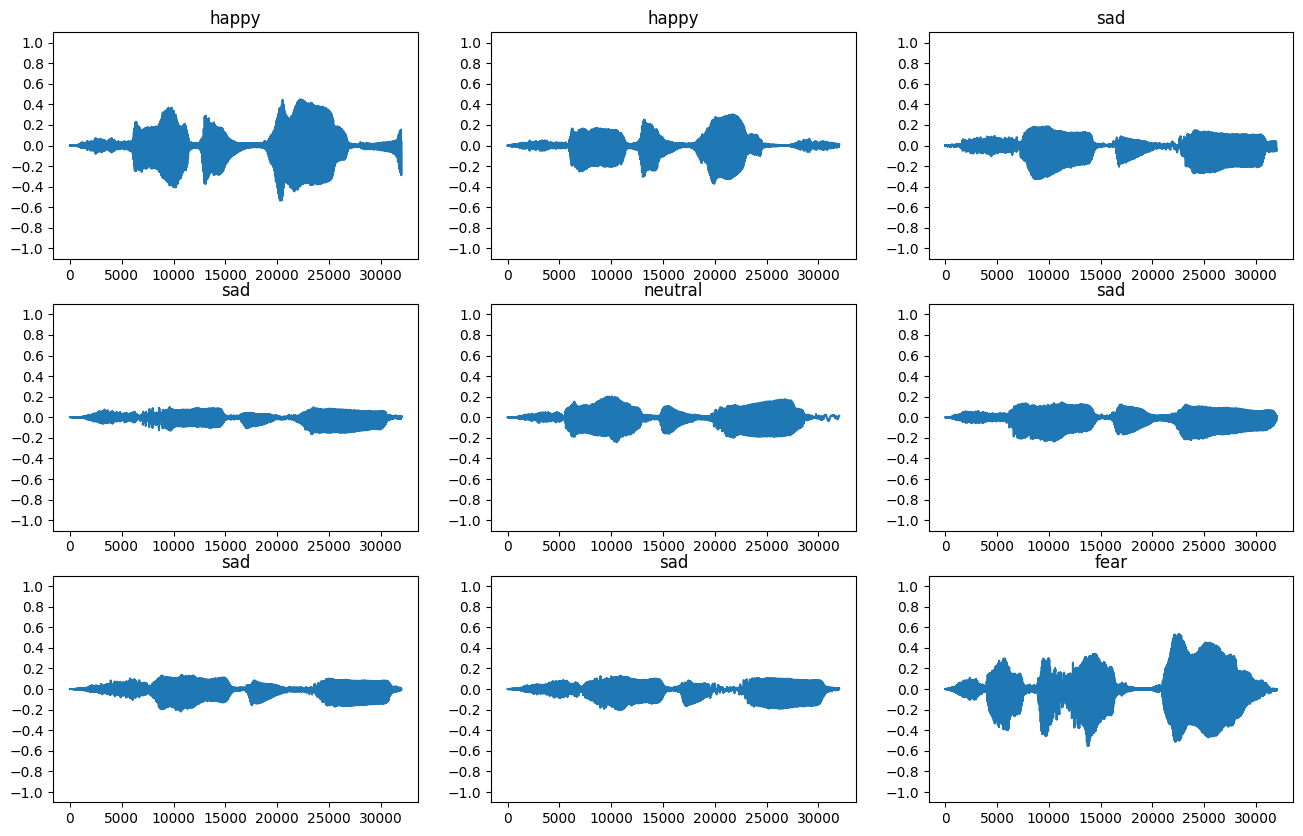

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: happy
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: happy
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: sad
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

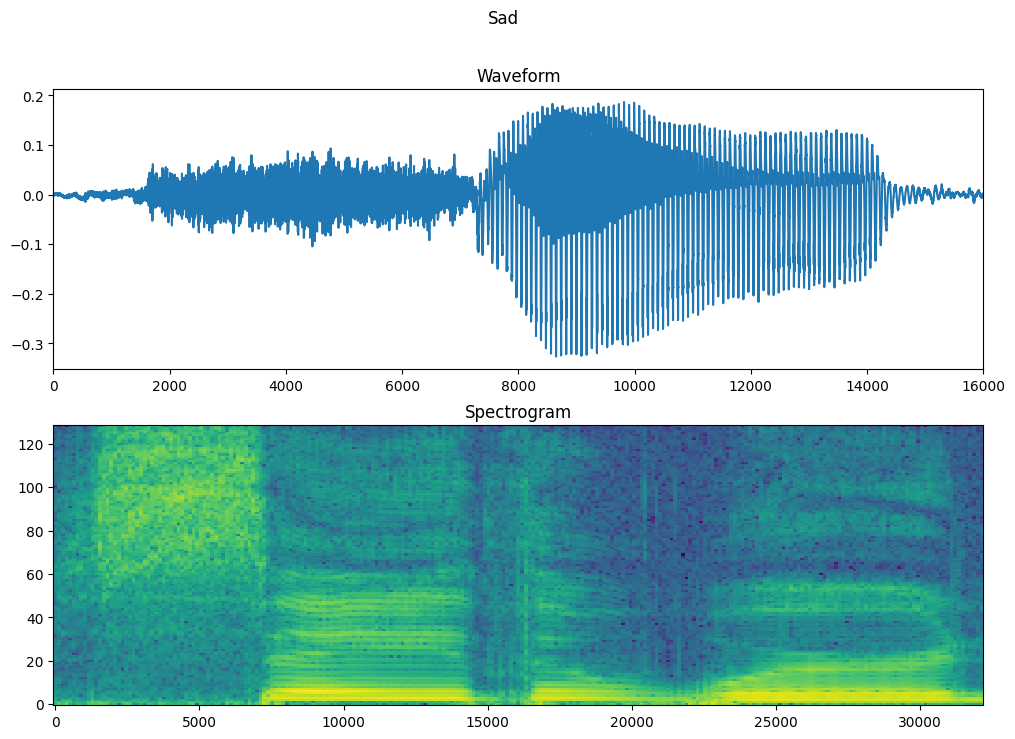

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

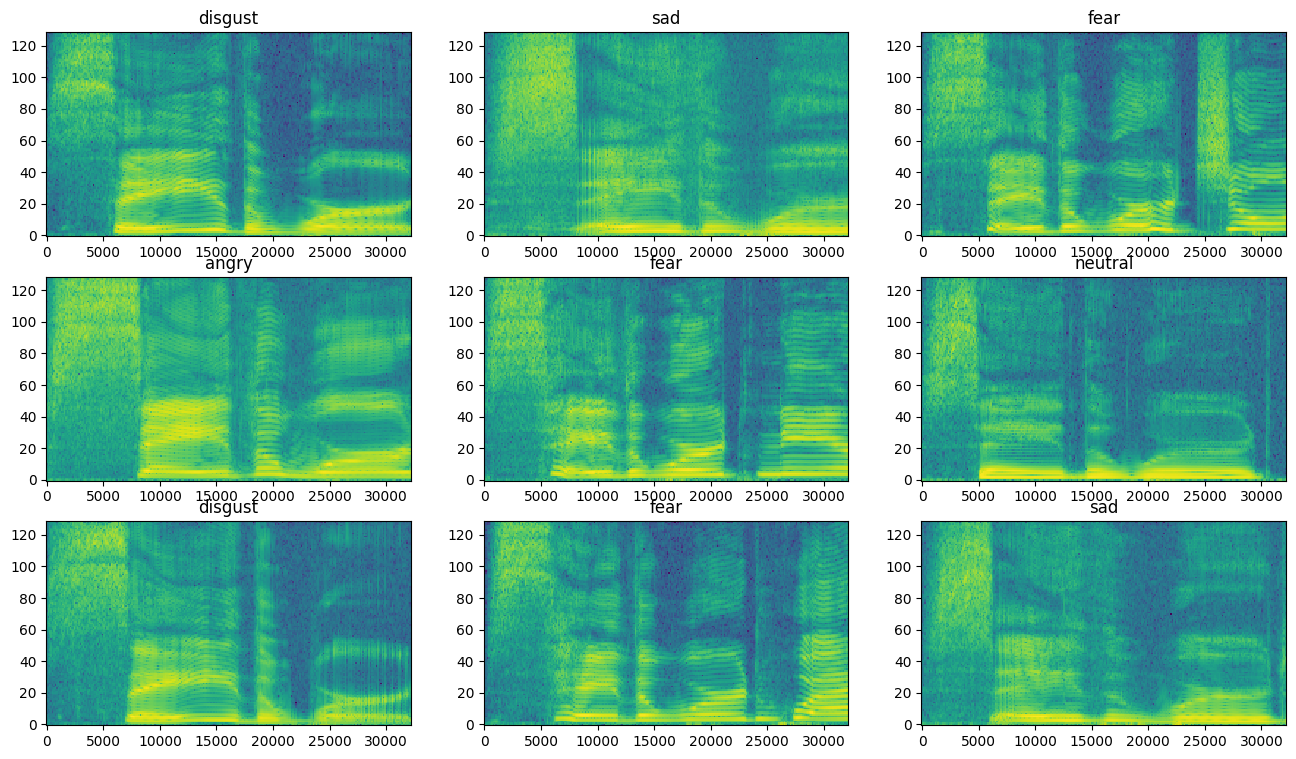

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (249, 129, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


17/17 [==============================] - 1s 46ms/step - loss: 1.0920 - accuracy: 0.6264 - val_loss: 0.3284 - val_accuracy: 0.9297
Epoch 2/10
17/17 [==============================] - 1s 37ms/step - loss: 0.2837 - accuracy: 0.9136 - val_loss: 0.1174 - val_accuracy: 0.9688
Epoch 3/10
17/17 [==============================] - 1s 36ms/step - loss: 0.1202 - accuracy: 0.9693 - val_loss: 0.0601 - val_accuracy: 0.9844
Epoch 4/10
17/17 [==============================] - 1s 37ms/step - loss: 0.1036 - accuracy: 0.9638 - val_loss: 0.0567 - val_accuracy: 0.9844
Epoch 5/10
17/17 [==============================] - 1s 36ms/step - loss: 0.0621 - accuracy: 0.9814 - val_loss: 0.0402 - val_accuracy: 0.9922
Epoch 6/10
17/17 [==============================] - 1s 36ms/step - loss: 0.0513 - accuracy: 0.9814 - val_loss: 0.0218 - val_accuracy: 0.9922
Epoch 7/10
17/17 [==============================] - 1s 36ms/step - loss: 0.0442 - accuracy: 0.9879 - val_loss: 0.0352 - val_accuracy: 0.9922
Epoch 8/10
17/17 [======

Text(0, 0.5, 'Accuracy [%]')

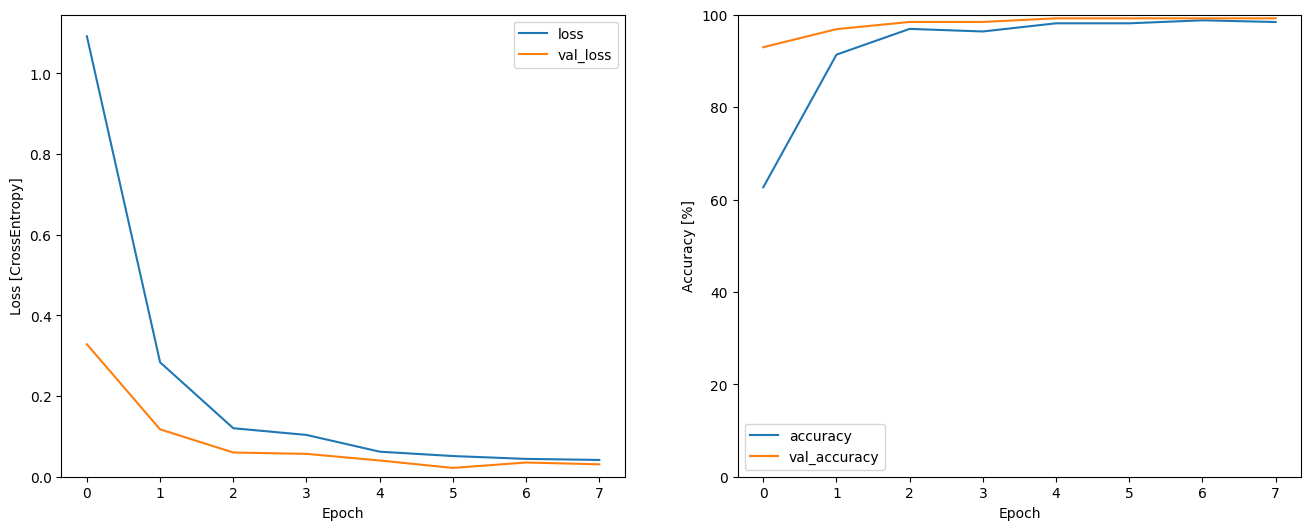

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

3/3 [==============================] - 0s 8ms/step - loss: 0.0249 - accuracy: 0.9929


{'loss': 0.0248862411826849, 'accuracy': 0.9928571581840515}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

3/3 [==============================] - 0s 6ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

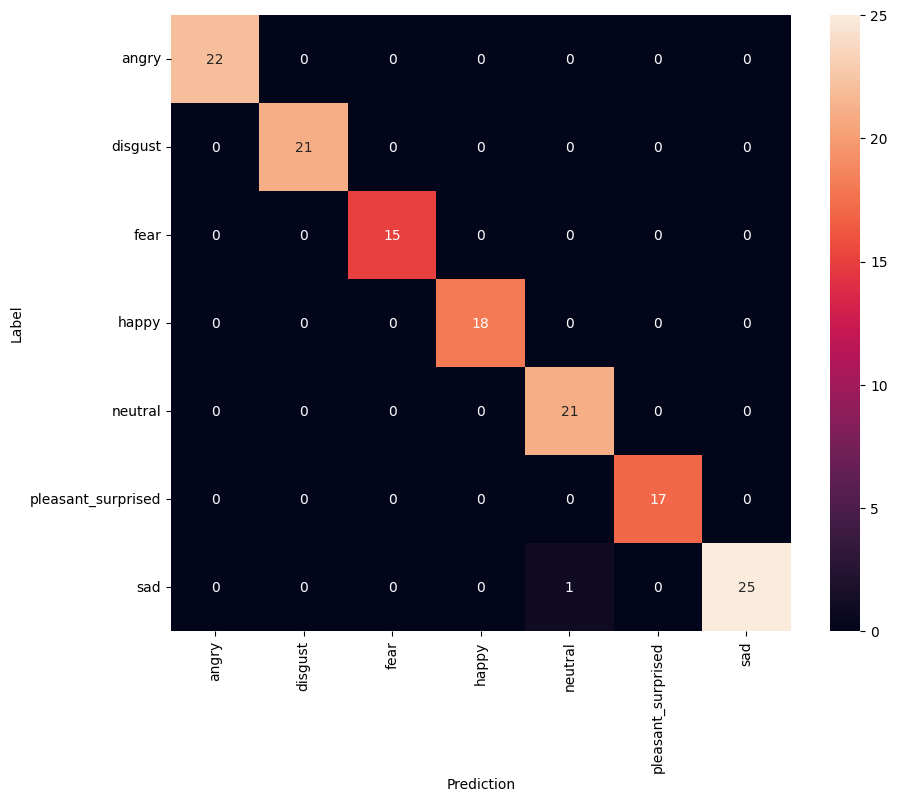

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

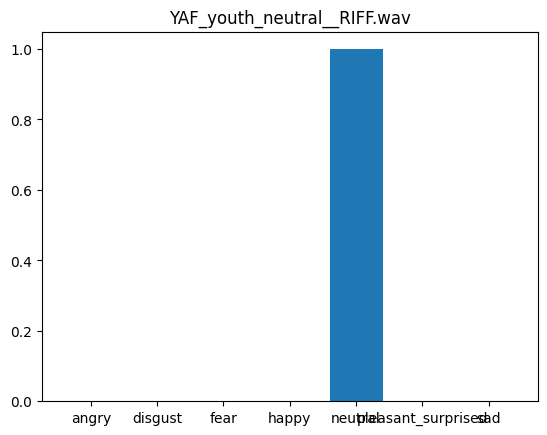

YAF_youth_neutral__RIFF.wav


In [ ]:
import random

test_data_dir = pathlib.Path(TEST_DATASET_PATH)
files = os.listdir(test_data_dir)
x = os.path.join(test_data_dir, random.choice(files))
selected_file = os.path.basename(x)

# Read the file
x = tf.io.read_file(str(x))
# Decode the WAV file
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=OUTPUT_SEQUENCE_LENGTH,)
# Squeeze to remove the channel dimension
x = tf.squeeze(x, axis=-1)
# Save the waveform for later display
waveform = x.numpy()
# Extract spectrogram
x = get_spectrogram(x)
# Add a batch dimension
x = x[tf.newaxis, ...]

# Make predictions using the trained model
prediction = model(x)

# Define the emotion labels
x_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprised', 'sad']

# Plot the softmax probabilities
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(selected_file)
plt.show()

# Display the audio waveform
display.display(display.Audio(waveform, rate=16000))
print(selected_file)


In [ ]:
selected_file

'data/Human Emotional Speech YAF/Test/YAF_yes_happy__RIFF.wav'